In [451]:
import os


import torch
import torch.nn as nn
from torch.autograd import Variable

try:
    import torchinfo
    no_torchinfo = False
except ModuleNotFoundError:
    no_torchinfo = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import torch.nn.init as init

torch loaded; device is cpu


In [452]:
class Discontinuity(torch.nn.Module):
    def __init__(self, a=1.):

        super().__init__()
        #Model parameters
        # self.c1 = torch.nn.Parameter(torch.randn(()))
        # self.c2 = torch.nn.Parameter(torch.randn(()))
        # self.c3 = torch.nn.Parameter(torch.randn(()))
        # self.c4 = torch.nn.Parameter(torch.randn(()))
        # self.b = torch.nn.Parameter(torch.randn(()))
        self.c1 = torch.nn.Parameter(nn.init.uniform_(torch.empty(()), 0, 1))
        self.c2 = torch.nn.Parameter(nn.init.uniform_(torch.empty(()), 0, 1))
        self.c3 = torch.nn.Parameter(nn.init.uniform_(torch.empty(()), 0, 1))
        self.c4 = torch.nn.Parameter(nn.init.uniform_(torch.empty(()), 0, 1))
        self.b = torch.nn.Parameter(nn.init.uniform_(torch.empty(()), 0, 1))
        self.sparse_layer=False
    
    def x(self, t):
        x_0 = torch.tensor(0.40) 
        return x_0 + self.c4 * t
    
    def forward(self, x, t):
        
        x_t = self.x(t)

        gamma = torch.tensor(10000)
    
        i1 = torch.sigmoid(gamma * x * (x_t - x))
        i2 = torch.sigmoid(gamma * (x - x_t) * ((x_t + self.b) - x))
        i3 = torch.sigmoid(gamma * (x - (x_t + self.b)) * (1. - x))
        
        # i1 = torch.where((0 <= x) & (x <= x_t), torch.tensor(1.0), torch.tensor(0.0))
        # i2 = torch.where((x_t < x) & (x <= x_t + self.b), torch.tensor(1.0), torch.tensor(0.0))
        # i3 = torch.where((x_t+self.b < x ) & (x<= torch.tensor(1.0)), torch.tensor(1.0), torch.tensor(0.0))
        
        return self.c1 * i1 + self.c2 * i2 + self.c3 * i3
    
def network_BC(t):
    return t

In [453]:
class Parameters:
     def __init__(self, tf, file_name):
        self.xmin = 0.
        self.xmax = 1.
        self.tmin = 0.
        self.tmax = tf
        self.learning_rate = 1e-3 #1e-3
        self.file_name = file_name
        self.a = 1.
        self.A = 0.7 
        self.B = 0.3 

     def u0(self, x):
         a = 0.40
         b = 0.50
         gamma = 10000  # You can adjust this parameter for the steepness of the sigmoid

         sigmoid_term = torch.sigmoid(gamma * (x - a) * (b - x))
         return sigmoid_term * self.A + (1 - sigmoid_term) * self.B   

In [454]:
class Network:

    def __init__(self,param: Parameters):

        """Initializes the neural network model"""
        self.parameters = param 
        self.x_min, self.x_max = param.xmin, param.xmax
        self.t_min, self.t_max = param.tmin, param.tmax
        self.learning_rate = param.learning_rate
        self.tf = param.tmax
        self. u0 = param.u0
        self.a = param.a    
        self.file_name = param.file_name
        self.A = param.A
        self.B = param.B
        
        #To save the model
        script_dir = os.getcwd()
        self.file_name = os.path.join(script_dir, self.file_name)

        self.create_network() #returns the current working directory
        self.load(self.file_name)
        
    """This method calls the neural network model"""
    def __call__(self, *args):
        return self.net(*args)

    def create_network(self):
        """Creates the neural network model"""
        self.net = Discontinuity().to(device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learning_rate)
   
    def load(self, file_name):
        self.loss_history = []
        try:

            try:
                checkpoint = checkpoint = torch.load(file_name, map_location=torch.device('cpu'))
                
            except RuntimeError:
                checkpoint = torch.load(file_name, map_location=torch.device('cpu'))

            self.net.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.loss = checkpoint['loss']

            try:
                self.loss_history = checkpoint['loss_history']
            except KeyError:
                pass

            self.to_be_trained = False
            print("network loaded successfully")
    
        except FileNotFoundError:

            self.to_be_trained = True
            print("network was not loaded from file: training needed")
    
    @staticmethod
    def save(file_name, epoch, net_state, optimizer_state, loss, loss_history):
        torch.save({
            epoch: epoch,
            'model_state_dict': net_state,
            'optimizer_state_dict': optimizer_state,
            'loss': loss,
            'loss_history': loss_history,
        }, file_name)

    def pde(self, x, t):

        u = self.u0(x) + network_BC(t) * self(x, t)
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0] # it enables the creation of a computational graph for the gradients. A computational graph is a data structure that represents the operations performed on tensors and their dependencies, which allows for automatic differentiation and backpropagation.
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] 
        
        return u_t + self.a * u_x

    
    """This method predicts the value of u based on the given input variables x, t and u0"""

    def predict_u_from_torch(self, x, t): # x tensor pour lequel on calcule la solution, t float, u0 float qu'on converti en tensor 
        ones = torch.ones(x.shape, dtype=torch.double, device=device)

        pt_t = t * ones
        pred = self.u0(x) + network_BC(pt_t) * self(x, pt_t)

        return pred
    
    @staticmethod
    def random(min_value, max_value, shape, requires_grad=False, device=device):
        random_numbers = torch.rand(shape, device=device, dtype=torch.double, requires_grad=requires_grad)
        return min_value + (max_value - min_value) * random_numbers
    
    """This method generates the data for the training process"""
    def make_data(self, n_data):
        
        shape = (n_data, 1)
        """We generate for each variable a random number between the min and max value"""
        self.x_data = Network.random(self.x_min, self.x_max, shape)
        self.t_data = Network.random(self.t_min, self.t_max, shape)
       
        self.u_data_exact = Network.u_exact(self.x_data, self.t_data, self.a ,self.x_max, self.u0) # la solution exacte evaluée dans (xi,ti)
        self.zeros1 = torch.zeros(shape, dtype=torch.double, device=device) 
        
    """This method generates the collocation points for the training process to enforce 
       the partial differential equation (PDE) constraints during training."""
    
    def make_collocation(self, n_collocation):

        shape = (n_collocation, 1)
        #These variables will be used to evaluate the PDE at the collocation points.
        #collocation points are additional points where the PDE will be evaluated to ensure that the neural network solution satisfies the PDE
        self.x_collocation = Network.random(self.x_min, self.x_max, shape, requires_grad=True)
        self.t_collocation = Network.random(self.t_min, self.t_max, shape, requires_grad=True)

        self.zeros = torch.zeros(shape, dtype=torch.double, device=device) #This will be used as a target for the PDE constraints.

    """This method trains the neural network using a combination of PDE constraints and data fitting."""
    def train(self, epochs, n_collocation, n_data):

        mse_cost_function = torch.nn.MSELoss()

        try:
            best_loss_value = self.loss.item()
        except AttributeError:
            best_loss_value = 1e10

        for epoch in range(epochs):

            self.optimizer.zero_grad()

            self.loss = 0


            if n_collocation > 0:
                # Loss based on PDE constraints
        
                self.make_collocation(n_collocation)
                f_out = self.pde(self.x_collocation, self.t_collocation, self.mean_collocation, self.variance_collocation)
                mse_f = mse_cost_function(f_out, self.zeros)
                self.loss += mse_f
            

            if n_data > 0:
                # Loss based on data fitting (on apprend que avec des donées)
                self.make_data(n_data)
                u_pred = self.predict_u_from_torch(self.x_data, self.t_data) #reseau evaluée dans (xi,ti)
                #on essaie de minimizer la différence entre la solution exacte et la solution du réseau calculées en (xi,ti)
                mse_data = mse_cost_function(u_pred, self.u_data_exact) 
                
                self.loss += mse_data

            """Losses based on a combination of PDE constraints in the interior and boundary conditions""" 

            """data points"""
            xmin_tensor = torch.full(self.x_data.size(), self.x_min, dtype=torch.double, device=device, requires_grad=True)
            xmax_tensor = torch.full(self.x_data.size(), self.x_max, dtype=torch.double, device=device, requires_grad=True)
            tmin_tensor = torch.full(self.t_data.size(), self.t_min, dtype=torch.double, device=device, requires_grad=True)
            tmax_tensor = torch.full(self.t_data.size(), self.t_max, dtype=torch.double, device=device, requires_grad=True)
          
            """To enforce the boundary conditions, we evaluate the neural network solution at the boundary points and compare it to the boundary values."""
            #boundary (periodicity) in x
            f_boundary1 = self.predict_u_from_torch(xmin_tensor, self.t_data)
            f_boundary2 = self.predict_u_from_torch(xmax_tensor, self.t_data)
            f_boundaryx= torch.abs(f_boundary1 - f_boundary2)
            mse_f_boundaryx = mse_cost_function(f_boundaryx, self.zeros1)

            #boundary (periodicity) in t
            f_boundary3 = self.predict_u_from_torch(self.x_data, tmin_tensor)
            f_boundary4 = self.predict_u_from_torch(self.x_data, tmax_tensor)
            f_boundaryt= torch.abs(f_boundary3 - f_boundary4)
            mse_f_boundaryt = mse_cost_function(f_boundaryt, self.zeros1)

            #Initial condition
            f_initial = self.predict_u_from_torch(self.x_data, self.t_min)
            f_initial_real= self.u0(self.x_data)
            f_initiale = torch.abs(f_initial - f_initial_real)
            mse_f_initial = mse_cost_function(f_initiale, self.zeros1)

            self.loss += mse_f_initial + mse_f_boundaryx + mse_f_boundaryt  

            #on fait la backpropagation et on met à jour les poids
            self.loss.backward() # This is for computing gradients using backward propagation
            self.optimizer.step() #This is equivalent to the update step in the gradient descent algorithm
    
            self.loss_history.append(self.loss.item())

            if epoch % 500 == 0:
                print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")
                try:
                    self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
                except NameError:
                    pass

            if self.loss.item() < best_loss_value:
                print(f"epoch {epoch: 5d}: best loss = {self.loss.item():5.2e}")
                best_loss = self.loss.clone()
                best_loss_value = best_loss.item()
                best_net = self.net.state_dict().copy()
                best_optimizer = self.optimizer.state_dict().copy()

        print(f"epoch {epoch: 5d}: current loss = {self.loss.item():5.2e}")

        try:
            self.save(self.file_name, epoch, best_net, best_optimizer, best_loss, self.loss_history)
            self.load(self.file_name)

        except UnboundLocalError:
            pass
    
    @staticmethod
    def u_exact(x, t, a, xmax, u0, device=device):
        return u0((x - a * t) % xmax)
    

    def L2_error(self, t, mean, variance):
        norm = 0
        n = 10000
        delta_x = 1 / n

        x = torch.linspace(0, 1, n, dtype=torch.double, device=device)[:, None]

        diff = Network.u_exact(x, t, self.a, self.x_max, self.u0, mean, variance) - self.predict_u_from_torch(x, t, mean, variance)
        
        for j in range(len(x)):
            norm += (diff[j - 1] ** 2 + diff[j] ** 2) * delta_x / 2
            
        return norm.float()
    
    
    def plot(self, t):

            _, ax = plt.subplots(1, 3, figsize=(15, 5))

            ax[0].semilogy(self.loss_history)
            ax[0].set_title("loss history")
      
            n_visu = 10000

            x = torch.linspace(0, 1, n_visu, dtype=torch.double, device=device)[:, None]
    
            u_pred = self.predict_u_from_torch(x, t)
            u_exact = Network.u_exact(x, t, self.a, self.x_max, self.u0)

            ax[1].plot(x.cpu(), u_exact.detach().cpu(), label="Exact solution")
            ax[1].plot(x.cpu(), u_pred.detach().cpu(), label="Prediction (NN)")
            ax[1].set_title("Prediction")
            ax[1].legend()

            error = torch.abs(u_pred - u_exact).detach().cpu()

            ax[2].plot(x.cpu(), error)
    
            ax[2].set_title("Prediction error")
           

In [455]:
epocs = 10000
n_collocation = 0
n_data = 50000
filename = "solution53"


params = Parameters(tf= 0.3, file_name=filename)
network = Network(params)
print("c1:", network.net.c1.detach().numpy())
print("c2:", network.net.c2.detach().numpy())
print("c3:", network.net.c3.detach().numpy())
print("c4:", network.net.c4.detach().numpy())
print("b:", network.net.b.detach().numpy())
network.train(epocs, n_collocation, n_data)

network was not loaded from file: training needed
c1: 0.18897212
c2: 0.0047422647
c3: 0.5116129
c4: 0.98155844
b: 0.9433994
epoch     0: current loss = 3.19e-02
epoch     0: best loss = 3.19e-02
epoch     4: best loss = 3.14e-02
epoch     7: best loss = 3.13e-02
epoch    10: best loss = 3.11e-02
epoch    17: best loss = 3.10e-02
epoch    18: best loss = 3.05e-02
epoch    30: best loss = 3.04e-02
epoch    31: best loss = 3.02e-02
epoch    36: best loss = 3.00e-02
epoch    43: best loss = 2.99e-02
epoch    45: best loss = 2.97e-02
epoch    51: best loss = 2.97e-02
epoch    56: best loss = 2.97e-02
epoch    57: best loss = 2.94e-02
epoch    67: best loss = 2.91e-02
epoch    73: best loss = 2.90e-02
epoch    77: best loss = 2.89e-02
epoch    79: best loss = 2.89e-02
epoch    82: best loss = 2.88e-02
epoch    85: best loss = 2.83e-02
epoch   111: best loss = 2.82e-02
epoch   112: best loss = 2.81e-02
epoch   116: best loss = 2.80e-02
epoch   123: best loss = 2.79e-02
epoch   127: best loss 

t = 0.0


t = 0.1
t = 0.2
t = 0.3


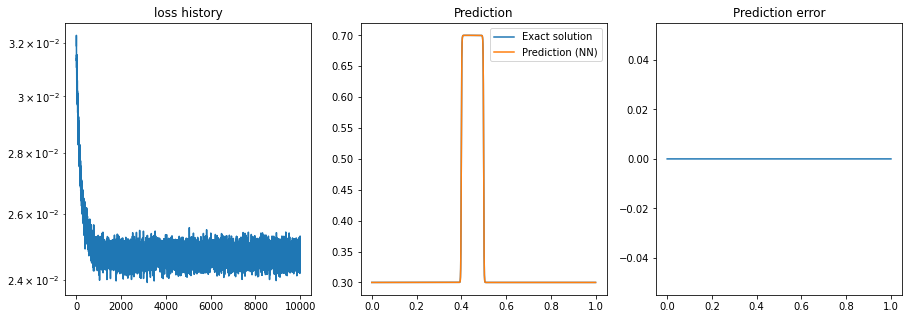

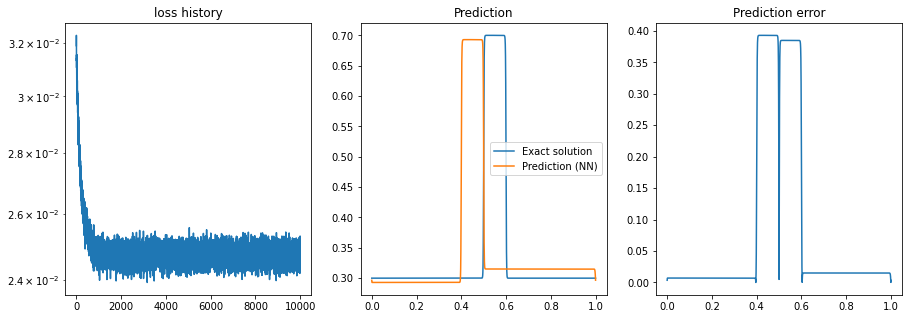

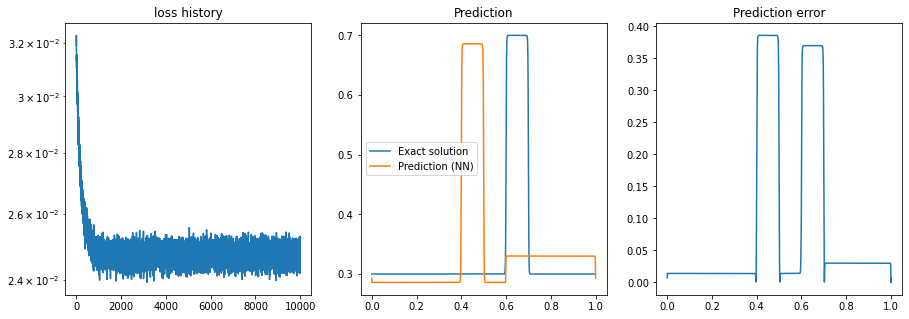

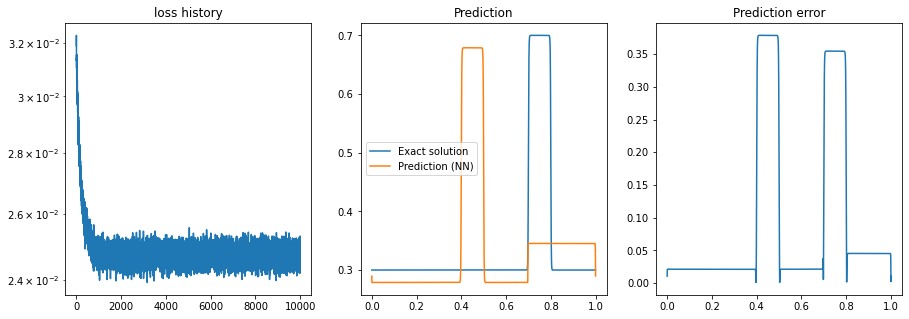

In [456]:
temps = [0., 0.1, 0.2, network.tf]

for t in temps:
    print(f"t = {t}")
    network.plot(t)


In [457]:
#We print the values of the parameters
print("c1:", network.net.c1.detach().numpy())
print("c2:", network.net.c2.detach().numpy())
print("c3:", network.net.c3.detach().numpy())
print("c4:", network.net.c4.detach().numpy())
print("b:", network.net.b.detach().numpy())
# valeur à avoir 
# C1 = 0.3 
# C2 = 0.7
# C3 = 0.3 
# Beta = 0.1 
# C4 approx 0

c1: -0.070565715
c2: 0.15094839
c3: -0.36943415
c4: 0.9919902
b: 0.5878742
